### Q-Planning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import random

### Tabular Dyna-Q

In [3]:
RG = np.random.RandomState(12)
# Initialize Q(s, a) and Model(s, a) for all s ∈ S and a ∈ A(s)
def DynaQ(Q, ModelReward, ModelState1, Sequence, n, alpha, gamma, UNOBSERVED):
    global RG
    # Loop forever:
        # (a) S ← current (nonterminal) state
        # (b) A ← ε-greedy(S, Q)
        # (c) Take action A; observe resultant reward, R, and state, S`
    for state, is_terminal, next_state, action, reward in Sequence:
        # (d) Q(S, A) ← Q(S, A) + α*[R + γ*max(a)Q(S`, a) - Q(S, A)]
        Q[state][action] = Q[state][action] + alpha*( reward + gamma*max(Q[next_state]) - Q[state][action])
        # (e) Model(S, A) ← R, S` (assuming deterministic environment)
        ModelReward[state][action] = reward
        ModelState1[state][action] = next_state
        # (f) Loop repeat n times:
        observed = np.transpose(np.nonzero((ModelState1 != UNOBSERVED).all(axis=-1)))
        for sample in RG.randint(len(observed), size=n):
            #   S ← random previously observed state
            #   A ← random action previously taken in S
            SA = tuple(observed[sample])
            ### S = SA[:-1]
            ### A = SA[-1]
            #   R, S` ← Model(S, A)
            R = ModelReward[SA]
            S1 = tuple(ModelState1[SA])
            #   Q(S, A) ← Q(S, A) + α*[R + γ*max(a)Q(S`, a) - Q(S, A)]
            Q[SA] = Q[SA] + alpha*( R + gamma*max(Q[S1]) - Q[SA])


### Generic sequence generator

In [4]:
class SequenceGenerator:
    def __init__(self, getAction, getStartState, getTransition, episode_imax=1, steps_max=0,
                callBack=None):
        self.episode_imax = episode_imax
        self.get_action = getAction
        self.get_start_state = getStartState
        self.get_transition = getTransition
        self.steps_max = steps_max
        self.callback = callBack

    def __iter__(self):
        self.episode_i=1
        self.state = self.get_start_state(self.episode_i)
        self.step_i = 1
        return self

    def __next__(self):
        if self.episode_imax > 0 and self.episode_i > self.episode_imax or \
            self.steps_max > 0 and self.step_i > self.steps_max:
            raise StopIteration

        action = self.get_action(self.state, self.episode_i)
        keep_state = self.state
        is_terminal, self.state, reward = self.get_transition(keep_state, action)
        if self.callback: self.callback(self.episode_i, self.step_i, reward)
        self.step_i += 1
        self.episode_i += int(is_terminal)
        return keep_state, is_terminal, self.state, action, reward

REWARD_I = 4
STATE_I = 0

# TODO: rid of global variables
random_generator = np.random.RandomState(11)

class EpsilonGreedyPolicy:
    def __init__(self, Q, Epsilon=0.1):
        self.Q = Q;
        self.epsilon = Epsilon
        
    def __call__(self, state, episode_i=1):
        global random_generator
        q = self.Q[state]
        if random_generator.rand(1)[0] < self.epsilon:
            val = random_generator.randint(0,len(q))
        else:
            val = np.argmax(q)
        return val

### Setup of Maze Problem

In [5]:
maze_shape = (6,9,)
maze_obstacles_1 = [[2,1,3,9]]
start_cell_1 = (0,3)
target_cell_1 = (5,8)

maze_obstacles_2 = [[2,1,3,8]]
maze_obstacles_3 = [[2,2,5,3], [1,5,2,6], [3,7,6,8]]
OBSTACLE_TAG = 0
START_TAG = 2
start_cell = (0,3)
TARGET_TAG = 3
target_cell = (5,8)

def buildMaze(shape, obstacles, start, target):
    maze = np.ones(shape, dtype = np.uint8)
    for begin_row, begin_column, end_row, end_column in obstacles:
        for r in range(begin_row, end_row):
            for c in range(begin_column, end_column):
                maze[r,c] = OBSTACLE_TAG
    maze[start] = START_TAG
    maze[target] = TARGET_TAG
    return maze

maze1 = buildMaze(maze_shape, maze_obstacles_1, start_cell, target_cell)
maze2 = buildMaze(maze_shape, maze_obstacles_2, start_cell, target_cell)

In [6]:
# Actions legend: Up, Right, Down, Left
ACTIONS = np.array([[1,0], [0,1], [-1,0], [0,-1]])
ACTIONS_NUM = len(ACTIONS)
NO_REWARD = 0
REWARD = 1
UNOBSERVED = (-1,-1,)
shape = maze_shape + (ACTIONS_NUM,)

def maze_getTransition(maze, getStartState, state, action):
    next_state = tuple(np.array(list(state)) + ACTIONS[action])
    if not (next_state in np.ndindex(maze.shape) and maze[next_state] > 0):
        return (False, state, NO_REWARD)
    elif maze[next_state] == TARGET_TAG:
        return (True, getStartState(), REWARD)

    return (False, next_state, NO_REWARD)

### Shortcut Maze Setup

In [9]:
#Q = (np.random.random(shape)-0.5)*0.01
Q = np.zeros(shape)
ModelReward = np.zeros(shape)
ModelState1 = np.full(shape+(2,),-1)
alpha = 0.1
gamma = 0.95
n = 5
TotalReward = 0.0
Reward = [0.0]

maze = maze1
getStartCell = lambda e=1: start_cell_1
random_generator.seed(2)

def callback(e,s,r):
    global TotalReward
    TotalReward += r
    if s % 100 == 0: Reward.append(TotalReward)

gen = SequenceGenerator(EpsilonGreedyPolicy(Q, 0.1),
                        getStartCell,
                        lambda s,a: maze_getTransition(maze, getStartCell, s, a),
                        #getMazeTransition,
                        0,
                        6000,
                        callback
                       )
sequence = iter(gen)
DynaQ(Q, ModelReward, ModelState1, sequence, n, alpha, gamma, UNOBSERVED)

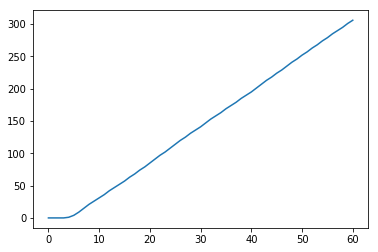

In [10]:
plt.plot(Reward)

In [ ]:
class DynaQPlus:
    def __init__(self, Q, factor):
        self.Q = Q
        self.counts = np.zeros(shape = Q.shape)
        
    def __getItem__(self, key):
        return self.Q[key] + factor*np.sqrt(self.counts[key])
    
    def __setItem__(self, key, value):
        self.Q[key] = value

#### Exercise 8.4

In [ ]:
alpha = 0.2
gamma = 0.95
n = 5
TotalReward = 0.0
Reward = [0.0]
PolicyQ = DynaQPlus(Q, 0.01)

def callback(e,s,r):
    global TotalReward
    TotalReward += r
    if s % 100 == 0: Reward.append(TotalReward)

gen = SequenceGenerator(EpsilonGreedyPolicy(PolicyQ, 0.1),
                        lambda e: start_cell_1,
                        lambda s,a: maze_getTransition(maze1, lambda: start_cell_1, s, a),
                        0,
                        3000,
                        callback
                       )
sequence = iter(gen)
DynaQ(Q, ModelReward, ModelState1, sequence, n, alpha, gamma, UNOBSERVED)

In [ ]:
alpha = 0.2
gamma = 0.95
n = 5
TotalReward = 0.0
Reward = [0.0]

def callback(e,s,r):
    global TotalReward
    TotalReward += r
    if s % 100 == 0: Reward.append(TotalReward)

gen = SequenceGenerator(EpsilonGreedyPolicy(Q, 0.4),
                        lambda e: start_cell_1,
                        lambda s,a: maze_getTransition(maze1, lambda: start_cell_1, s, a),
                        0,
                        3000,
                        callback
                       )
sequence = iter(gen)

In [ ]:
DynaQ(Q, ModelReward, ModelState1, sequence, n, alpha, gamma, UNOBSERVED)

In [ ]:
Reward

### Testing

In [ ]:
observed = np.transpose(np.nonzero((ModelState1 != UNOBSERVED).all(axis=-1)))
len(observed)

In [ ]:
state, is_terminal, next_state, action, reward = next(sequence)
# (d) Q(S, A) ← Q(S, A) + α*[R + γ*max(a)Q(S`, a) - Q(S, A)]
Q[state][action] = Q[state][action] + alpha*( reward + gamma*max(Q[state]) - Q[state][action])
# (e) Model(S, A) ← R, S` (assuming deterministic environment)
ModelReward[state][action] = reward
ModelState1[state][action] = next_state
# (f) Loop repeat n times:
observed = np.transpose(np.nonzero((ModelState1 != UNOBSERVED).all(axis=-1)))
len(observed), state, next_state

In [ ]:
for sample in np.random.randint(len(observed), size=n):
    #   S ← random previously observed state
    #   A ← random action previously taken in S
    SA = tuple(observed[sample])
    ### S = SA[:-1]
    ### A = SA[-1]
    #   R, S` ← Model(S, A)
    R = ModelReward[SA]
    S1 = tuple(ModelState1[SA])
    #   Q(S, A) ← Q(S, A) + α*[R + γ*max(a)Q(S`, a) - Q(S, A)]
    Q[SA] = Q[SA] + alpha*( R + gamma*max(Q[S1]) - Q[SA])
    print(SA,S1)

In [39]:
maze = maze1
getStartCell = lambda e=1: start_cell_1
random_generator.seed(1)
gen = SequenceGenerator(EpsilonGreedyPolicy(Q, 0.1),
                        getStartCell,
                        lambda s,a: maze_getTransition(maze, getStartCell, s, a),
                        1
                       )
sequence = iter(gen)

In [ ]:
DynaQ(Q, ModelReward, ModelState1, sequence, n, alpha, gamma, UNOBSERVED)

In [40]:
len(list(sequence))

1339

In [ ]:
x = np.array([[(1,66),(77,-33)],
              [(-3,2),(77,9)],
              [(0,31),(1,45)]])
#np.transpose(np.nonzero(x[...,0] == 1))
#(x == [-3,2]).all(axis = -1)
np.transpose(np.nonzero((x == [-3,2]).all(axis = -1)))
#x[...,1]

In [ ]:
import itertools

l = list(itertools.repeat((-1,-1,),10))
a = np.array(l)
b = a.reshape((2,5,2))
(b == (-1,-1))


In [11]:
Q = np.zeros(shape)
maze = buildMaze(maze_shape, maze_obstacles_1, start_cell_1, target_cell_1)

for seed_ in range(0,50):
    random_generator.seed(seed_)
    gen = SequenceGenerator(EpsilonGreedyPolicy(Q, 0.1),
                    lambda e: start_cell,
                    lambda s,a: maze_getTransition(maze, s, a),
                    1,
                    20000,
                   )
    sequence = iter(gen)
    if len(list(sequence)) < 20000: break
        
seed_

0

In [18]:
sequence = iter(gen)
gen.episode_i, len(list(sequence))

(1, 2161)

### Dyna Maze Setup

In [28]:
epsilon = 0.1
start_cell = (3,0)
target_cell = (5,8)
Maze3 = buildMaze(maze_shape, maze_obstacles_3, start_cell, target_cell)

class DynaMazeLearinig:
    def __init__(self, shape):
        self.Q = np.zeros(shape)
        self.ModelReward = np.zeros(shape)
        self.ModelState1 = np.full(shape+(2,),-1)
        
setup1 = DynaMazeLearinig(shape)
setup1.Q[...,1] = 1.e-9

In [29]:
steps_num = np.zeros(shape=(50,), dtype=np.int32)

def callback(e,s,r):
    global steps_num
    steps_num[e-1] = s

random_generator.seed(3)
gen = SequenceGenerator(EpsilonGreedyPolicy(setup1.Q, epsilon),
                lambda e: start_cell,
                lambda s,a: maze_getTransition(Maze3, s, a),
                50,
                0,
                callback
               )
sequence = iter(gen)
#len(list(sequence)), steps_num[0]

In [30]:
alpha = 0.1
gamma = 0.95

In [ ]:
n = 50
RG.seed(1)

DynaQ(setup1.Q, setup1.ModelReward, setup1.ModelState1, sequence, n, alpha, gamma, UNOBSERVED)

### Run Dyna Maze 3 times with n=0, n=5, n=50

In [31]:
rate = []

for n in [0,5,50]:
    random_generator.seed(3)
    setup1 = Learinig3(shape)
    setup1.Q[...,1] = 1.e-9
    
    gen = SequenceGenerator(EpsilonGreedyPolicy(setup1.Q, epsilon),
                    lambda e: start_cell,
                    lambda s,a: maze_getTransition(Maze3, s, a),
                    50,
                    0,
                    callback
                   )
    sequence = iter(gen)
    
    RG.seed(5)
    DynaQ(setup1.Q, setup1.ModelReward, setup1.ModelState1, sequence, n, alpha, gamma, UNOBSERVED)
    rate.append([steps_num[j]-steps_num[j-1] for j in range(1,len(steps_num))])

Plot the number of steps in each episode (excluding the first one) for all the three runs.

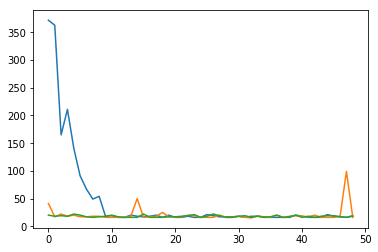

In [32]:
plt.plot(rate[0])
plt.plot(rate[1])
plt.plot(rate[2])

In [ ]:
setup1.Q[1,4]

In [ ]:
plt.plot([steps_num[j]-steps_num[j-1] for j in range(1,len(steps_num))])

### Draw the maze

In [ ]:
maze = Maze3
f = plt.figure(num=None, figsize=tuple(reversed(maze.shape)), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(maze, figure=f)

In [ ]:
RG1 = np.random.RandomState(1)
RG2 = np.random.RandomState(2)

In [ ]:
RG1.seed(1)
RG2.seed(2)

In [ ]:
[RG1.randint(0,4), RG1.randint(0,4), RG2.randint(0,4), RG1.randint(0,4), RG2.randint(0,4)]

In [ ]:
[RG2.randint(0,4), RG1.randint(0,4), RG2.randint(0,4), RG1.randint(0,4), RG1.randint(0,4)]

In [ ]:
RG2.rand(1)[0]